# Merge 12 files
#### function name: merge_stu_log(files_path) , input: files path list, output: DataFrame of all data

In [8]:
import pandas as pd
import numpy as np

def merge_stu_log(files_path):
    # Initial DataFrame
    df = pd.DataFrame()
    log1 = pd.read_csv(files_path[0])
    initial_col_order = [col.lower() for col in list(log1.columns)]
    # in loop
    for file in files_path:
        #load csv file as pandas
        student_log = pd.read_csv(file)
        student_log.columns = [col.lower() for col in student_log]
        df = pd.concat([df, student_log])

    df = df[initial_col_order]
    return df

In [9]:
student_log_list = ["../dataset/anonymized_dataset_for_ADM2017/student_log_{}.csv".format(i) for i in range(1,13)]
student_log = merge_stu_log(student_log_list)


/Users/liufangfei/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#  feature selection : nothing yet

#  correlation

In [10]:
# all 1709 students' id
student_id_list = pd.unique(student_log['itest_id'])
# useful features
coeffecient_name_list = ['itest_id','aveknow','avecarelessness','avecorrect','numactions','averesbored','averesengcon',
                         'averesconf','averesfrust','averesofftask','averesgaming']
student_log_uni = student_log[coeffecient_name_list]

# delete same lines
student_log_uni = student_log_uni.drop_duplicates().copy()
student_log_uni.reset_index(drop=True, inplace=True)
student_log_uni

,itest_id,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,averesofftask,averesgaming
0,8,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,0.156503,0.196561
1,35,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,0.153147,0.236800
2,39,0.281693,0.152227,0.454545,418,0.274700,0.628075,0.116390,0.143827,0.221926,0.019817
3,64,0.157938,0.098357,0.334038,1419,0.198394,0.670062,0.085895,0.132328,0.115773,0.303426
4,77,0.191948,0.094195,0.413249,317,0.261455,0.638636,0.063971,0.129858,0.234331,0.045096
5,126,0.250838,0.111159,0.500000,406,0.273188,0.646944,0.104602,0.131632,0.230005,0.040233
6,134,0.183801,0.113211,0.323420,269,0.267901,0.612556,0.133687,0.088761,0.238335,0.062208
7,156,0.271432,0.183643,0.384766,512,0.255130,0.637416,0.134121,0.110669,0.208373,0.052069
8,160,0.222439,0.146000,0.387009,739,0.234373,0.647306,0.106632,0.100563,0.139646,0.096695
9,164,0.117598,0.081440,0.256983,179,0.252204,0.597314,0.135032,0.105664,0.243513,0.214158


In [81]:
def all_lower(L1):
    return [s.lower() for s in L1]

training_dataset = pd.read_csv("../dataset/anonymized_dataset_for_ADM2017/training_label.csv")
training_dataset.columns = all_lower(training_dataset.columns.tolist())
training_dataset = training_dataset[all_lower(['ITEST_id','MCAS','isSTEM'])]
# training_dataset
training_set = student_log_uni.merge(training_dataset, on='itest_id', how="right")
training_set = training_set[training_set['mcas']!=-999]
training_set.reset_index(drop=True, inplace=True)
training_set

,itest_id,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,averesofftask,averesgaming,mcas,isstem
0,35,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,0.153147,0.236800,34,0
1,77,0.191948,0.094195,0.413249,317,0.261455,0.638636,0.063971,0.129858,0.234331,0.045096,39,0
2,126,0.250838,0.111159,0.500000,406,0.273188,0.646944,0.104602,0.131632,0.230005,0.040233,30,0
3,205,0.229988,0.126401,0.445407,577,0.242691,0.658863,0.112356,0.132230,0.185330,0.077827,29,0
4,283,0.146352,0.093224,0.309661,1211,0.211405,0.655711,0.079308,0.102920,0.126860,0.245489,11,0
5,360,0.150901,0.089865,0.327911,1168,0.221344,0.658256,0.101942,0.112645,0.137649,0.173189,16,0
6,391,0.116830,0.069112,0.291091,1302,0.199464,0.664513,0.084895,0.133488,0.113943,0.344927,11,0
7,473,0.082637,0.044334,0.204420,724,0.197508,0.686581,0.029042,0.127445,0.132935,0.423625,12,0
8,476,0.109229,0.069041,0.293760,1314,0.195516,0.687632,0.089651,0.124164,0.112046,0.348984,11,0
9,621,0.133110,0.074881,0.317147,659,0.230215,0.670287,0.099247,0.116014,0.184888,0.290471,15,0


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
def correlation(dataframe):
    corr = dataframe.corr()  
    sns.set(style="white")
    sns.heatmap(corr, annot=True)
    plt.show()
def histogram(feature,name):
    feature1=feature[name]
    plt.hist(feature1)
    plt.show()

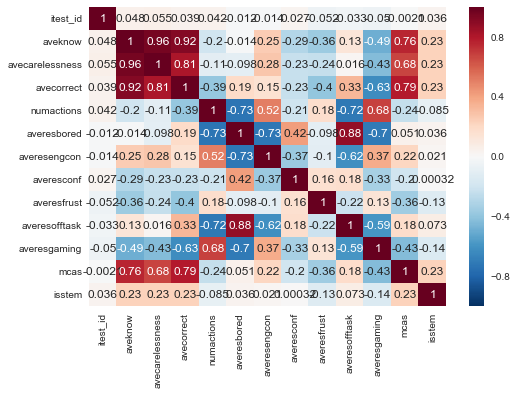

In [13]:
correlation(training_set)

feature name: aveknow


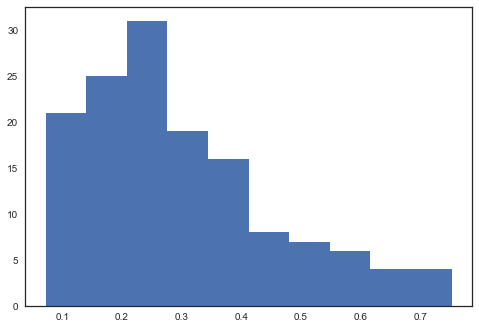

feature name: avecarelessness


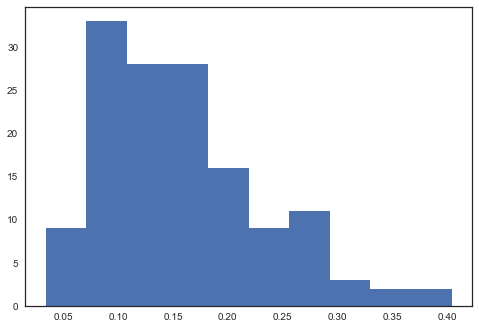

feature name: avecorrect


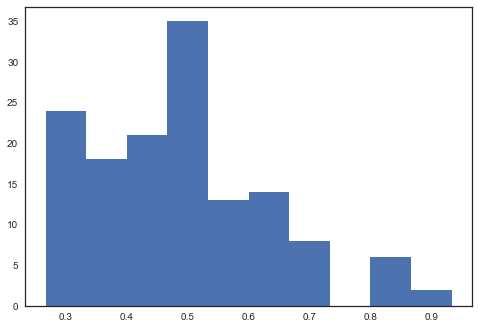

feature name: numactions


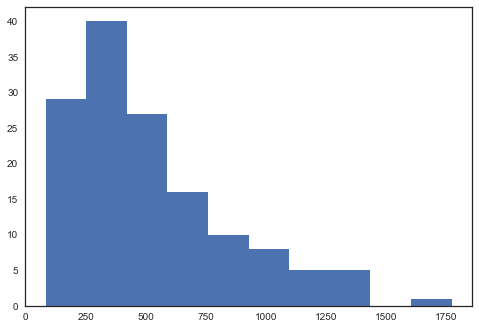

feature name: averesbored


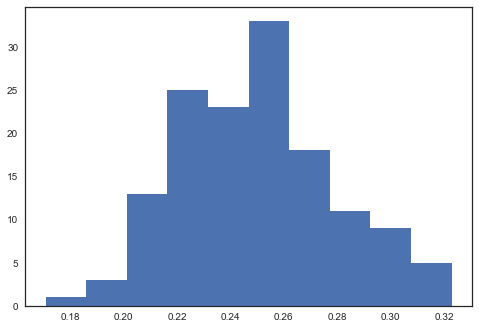

feature name: averesengcon


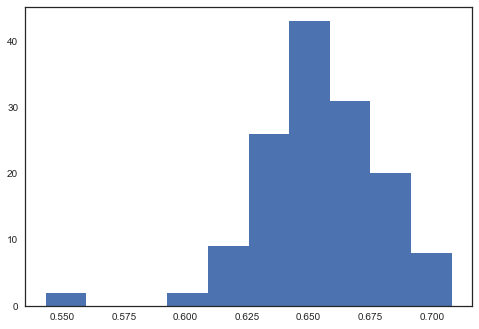

feature name: averesconf


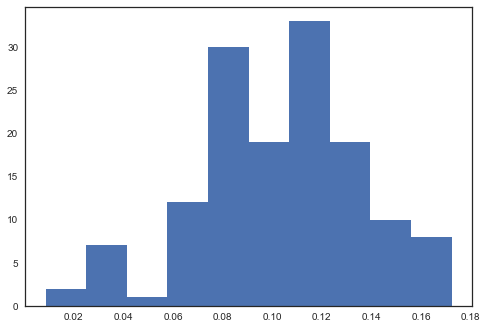

feature name: averesfrust


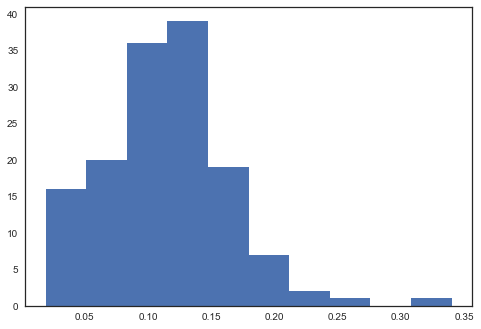

feature name: averesofftask


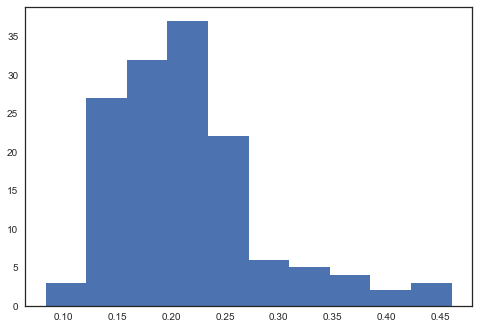

feature name: averesgaming


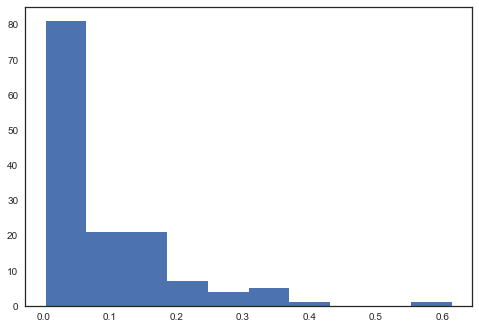

feature name: mcas


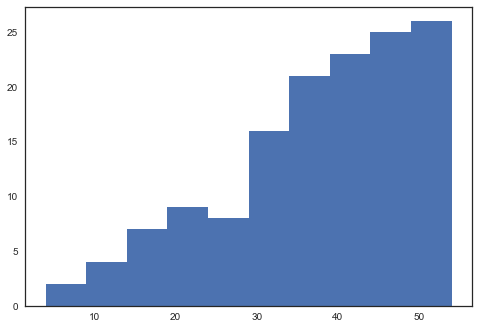

In [82]:
training_name = training_set.columns.tolist()
isSTEM = training_set[training_set['isstem']==1]
for name in training_name[1:-1]:
    print("feature name: %s" % name)
    histogram(isSTEM,name)

In [88]:
t=training_set
t1=t.iloc[:,1:-1]
t2=preprocessing.scale(t1)
t_id=t.iloc[:,0].values
t_isstem=t["isstem"]
dataframe=pd.DataFrame(t2,columns=['aveknow','avecarelessness','avecorrect','numactions','averesbored','averesengcon',
                         'averesconf','averesfrust','averesofftask','averesgaming','mcas'])
dataframe['itest_id'] = training_set['itest_id']
dataframe['isstem']=training_set['isstem']

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import preprocessing

def logistic(df,c):
    X=df.loc[:,['aveknow','avecarelessness','avecorrect','numactions','averesbored','averesengcon',
                         'averesconf','averesfrust','averesofftask','averesgaming','mcas']]
    X1=X.values   
    y=df['isstem']
    y1=y.values  
    kf=KFold(c,shuffle=True)
    accurate=[]
    for train_index, test_index in kf.split(X1):
        X_train,X_test=X1[train_index],X1[test_index]
        y_train,y_test=y1[train_index],y1[test_index]
        log=LogisticRegression()
        log.fit(X_train,y_train)
        acc=log.score(X_test,y_test)
        accurate.append(acc)
    mean_acc=np.mean(accurate)
    return(mean_acc)



In [97]:

df=dataframe
logistic(df,4)


0.66430858428521977

In [93]:
from sklearn.ensemble import RandomForestClassifier

def RandomFC(df,c,estimators):
    X=df.loc[:,['aveknow','avecarelessness','avecorrect','numactions','averesbored','averesengcon',
                         'averesconf','averesfrust','averesofftask','averesgaming','mcas']]
    X1=X.values
    y=df['isstem']
    y1=y.values
    kf=KFold(c,shuffle=True)
    accurate=[]
    for train_index, test_index in kf.split(X1):
        X_train,X_test=X1[train_index],X1[test_index]
        y_train,y_test=y1[train_index],y1[test_index]
        RFC=RandomForestClassifier(n_estimators=estimators,oob_score=True) 
        RFC.fit(X_train,y_train)
        acc=RFC.score(X_test,y_test)
        accurate.append(acc)
    mean_acc=np.mean(accurate)
    return(mean_acc)


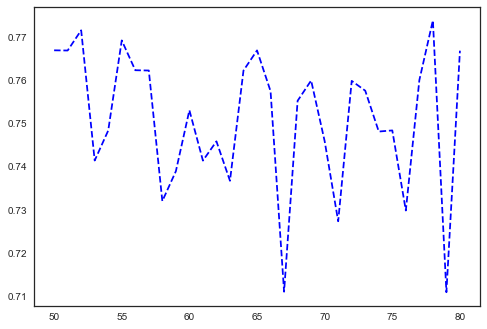

In [98]:
df=dataframe
acc_RFC=[]
rang=range(50,81,1)
for i in rang:
    acc_rfc=RandomFC(df,4,i)
    acc_RFC.append(acc_rfc)
plt.plot(rang,acc_RFC,"b--")
plt.show()
#std?